In [27]:
import os
import cv2 as cv
import numpy as np
from doctr.models import ocr_predictor
from inspection.support.utils import extract
from skimage.io import imshow
import imutils 
import pytesseract

In [2]:
model = ocr_predictor(det_arch='linknet_resnet34', reco_arch='crnn_vgg16_bn', pretrained=True, preserve_aspect_ratio=True)

In [33]:
OCR_MASK_COLOR = np.array([0, 0, 255])
ORIGINAL = "./inspection/support/um_camera/drawcore.bmp"
MASK = "./inspection/support/ocr/drawcore/d0.bmp"
TEXT = ".".join(os.path.basename(MASK).split(".")[:-1]).split('_')[0]

print(f"Detecting: '{TEXT}' at image: {ORIGINAL} under mask {MASK}")

Detecting: 'd0' at image: ./inspection/support/um_camera/drawcore.bmp under mask ./inspection/support/ocr/drawcore/d0.bmp


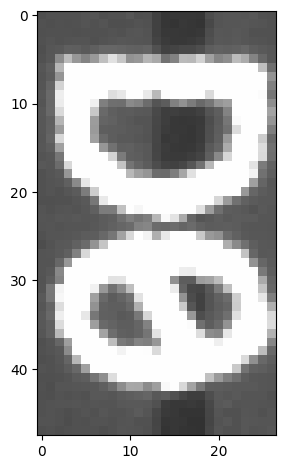

In [34]:
original = cv.cvtColor(
    cv.imread(ORIGINAL),
    cv.COLOR_BGR2GRAY,
)
mask = cv.cvtColor(
    cv.imread(MASK),
    cv.COLOR_BGR2RGB,
)
chunks, values = extract(original, OCR_MASK_COLOR, mask)
imshow(chunks[0])

48


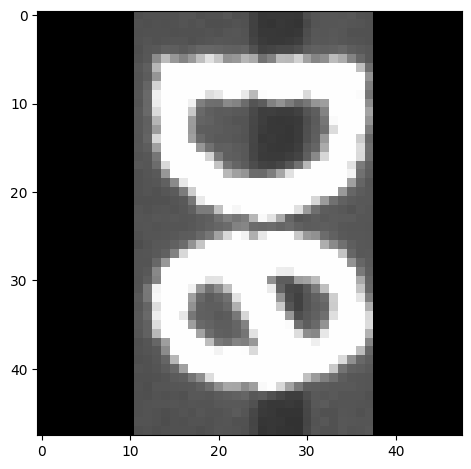

In [49]:
# Make image squared to support rotation
base = chunks[0]
im = imutils.resize(base, height=50)

s = max(base.shape)
print(s)

r = s
c = s
box = np.zeros((r, c))
r = int(r / 2) - int(base.shape[0] / 2)
c = int(c / 2) - int(base.shape[1] / 2)
box[r : r + base.shape[0], c : c + base.shape[1]] = base
base = box.astype(np.uint8)

imshow(base)

## Tesseract
Tesseract handles OCR in most cases, but fails with zeros with diagonal line for example (technical font).

De



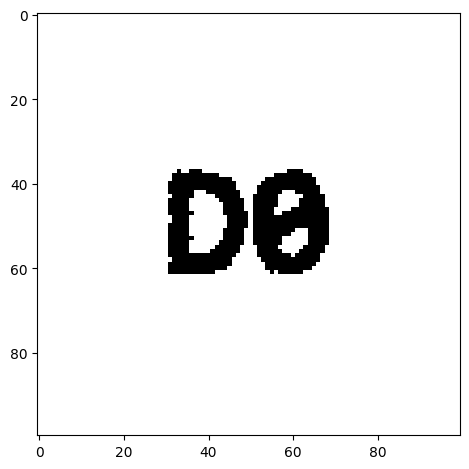

In [53]:
im = base
im = imutils.rotate(im, 90)
_, im = cv.threshold(im, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

r = 100
c = 100
box = np.zeros((r, c))
# print(im.shape)
r = int(r / 2) - int(im.shape[0] / 2)
c = int(c / 2) - int(im.shape[1] / 2)
box[r : r + im.shape[0], c : c + im.shape[1]] = im
box = 255 - box
im = box.astype(np.uint8)


im = cv.cvtColor(
    im,
    cv.COLOR_GRAY2RGB,
)

imshow(im)
print(pytesseract.image_to_string(im))

## DocTR
DocTR use double arch OCR model: first it detects text on image and then recognize characters. Text detection require some space on image (does not work if text fills whole space on image).

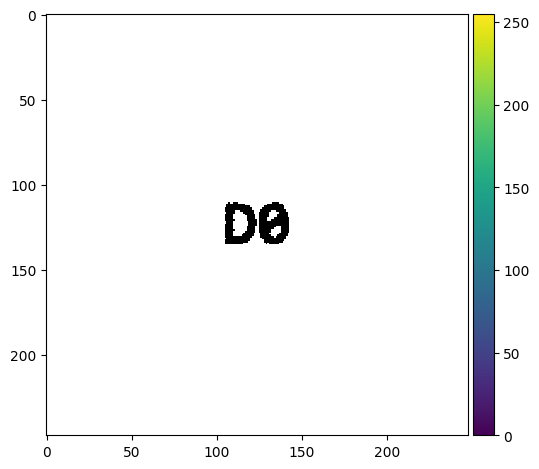

In [59]:
im = base
im = imutils.rotate(im, 90)

# coef = 0.5
# im = cv.resize(im, (int(im.shape[1] * coef), int(im.shape[0] * coef)))
_, im = cv.threshold(im, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# While it is possible to use direct image to text model, doctr use detector to locate text on image, this works only with some margins around text
# TODO: Remove margins by using recognition models
r = im.shape[0] + 200
c = im.shape[1] + 200
box = np.zeros((r, c))
# print(im.shape)
r = int(r / 2) - int(im.shape[0] / 2)
c = int(c / 2) - int(im.shape[1] / 2)
box[r : r + im.shape[0], c : c + im.shape[1]] = im
box = 255 - box
im = box.astype(np.uint8)

im = cv.cvtColor(
    im,
    cv.COLOR_GRAY2RGB,
)

imshow(im)

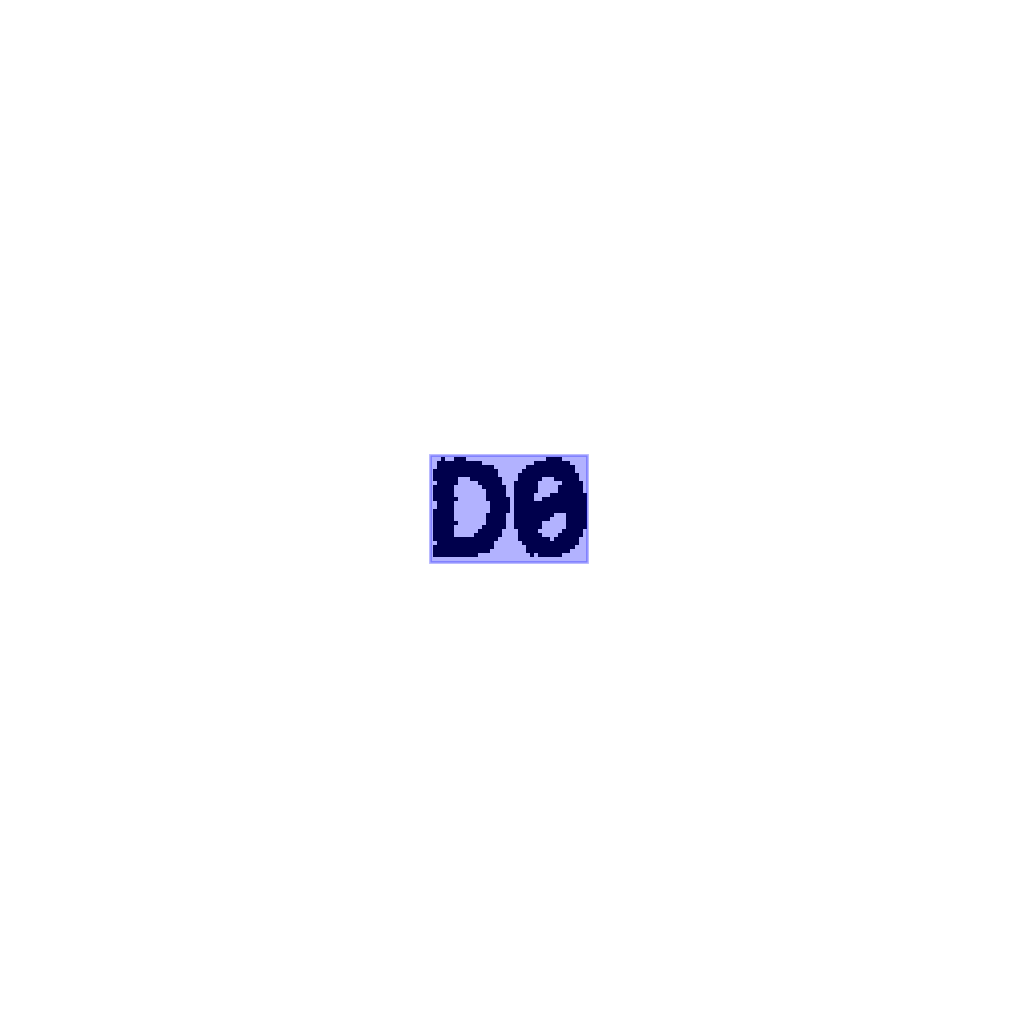

Document(
  (pages): [Page(
    dimensions=(248, 248)
    (blocks): [Block(
      (lines): [Line(
        (words): [Word(value='DO', confidence=0.98)]
      )]
      (artefacts): []
    )]
  )]
)

In [60]:
result = model([im])
result.show()
result